# Quick Start Tutorial
---

## Tutorial Example - Lipid class Prediction
This notebook showcases the use of GLC for lipid class prediction for untargeted lipidomic features for a reverse-phase lipidomics LC-MS assay. 
 
---
 
### GgmLipidClassifier (GLC)

The **GgmLipidClassifier (GLC)** is a workflow designed to systematically predict lipid classes directly from **MS1-only data** in untargeted LC–MS lipidomics.

GLC integrates two complementary sources of information within a unified scoring framework:

1. **Accurate-mass database matching:**  
   Features are tentatively assigned to candidate structures from the LIPID MAPS Structural Database (LMSD).  
   In this tutorial we are keeping this simple only conidering the [M+H]+ ion. In the following tutorial we will use a more sophisticated approach for database matching.

2. **Gaussian Graphical Models (GGM):**  
   A GGM is estimated from feature intensities, capturing conditional dependencies between features, and has been well shown to encode lipid class information. 

By combining the local network context provided by the GGM with tentative database matches, GLC generates refined predictions of lipid subclass.


In [1]:
# import the package
import glc

## Overview

This notebook demonstrates the use of **GLC** for lipid class prediction of **untargeted lipidomic features** acquired using a **reverse-phase LC–MS lipidomics assay**.

The dataset used in this notebook originates from the [AddNeuroMed](https://nyaspubs.onlinelibrary.wiley.com/doi/10.1111/j.1749-6632.2009.05064.x) cohort. The assays were processed by the [National Phenome Centre](https://phenomecentre.org/), and the **GLC** package includes the corresponding untargeted feature table as an example dataset for the LPOS assay with 4,886 features (reversed-phase chromatography in positive ionization mode). The data was prepcoessed using [XCMS](https://pubs.acs.org/doi/10.1021/ac051437y) and [nPYc-Toolbox](https://doi.org/10.1093/bioinformatics/btz566).


## Feature table requirements

For use with **GLC**, the feature table must contain at minimum:
- a unique feature identifier called (`peak_id`)
- mass-to-charge ratio or alternatvely neutral_mass for a grouped feature table (`m/z`)
- retention time in seconds (`rt`)
- intensity information for each sample

An example of the expected structure is shown below:

| peak_id | m/z     | rt | sample_1_intensity | sample_2_intensity|
|--------:|--------:|-------:|----------:|----------:|
| 1       | 760.585 | 312.4  | 1.23e6    |8.3e8|
| 2       | 782.569 | 298.7  | 8.45e5    |1.14e2|
| 3       | 734.569 | 341.2  | 2.10e6    |9.9e5|



In [2]:
# load the example feature table

ds = glc.LoadExampleData()
ds.feat_table.head()

,peak_id,mz,mzmin,mzmax,rt,rtmin,rtmax,ALZ_LPOS_ToF05_S10W01,ALZ_LPOS_ToF05_S10W02,ALZ_LPOS_ToF05_S10W03,...,ALZ_LPOS_ToF05_S18W85,ALZ_LPOS_ToF05_S18W86,ALZ_LPOS_ToF05_S18W87,ALZ_LPOS_ToF05_S18W88,ALZ_LPOS_ToF05_S18W89,ALZ_LPOS_ToF05_S18W90,ALZ_LPOS_ToF05_S18W91,ALZ_LPOS_ToF05_S18W92,ALZ_LPOS_ToF05_S18W95_LTR,ALZ_LPOS_ToF05_S18W96_SR
0,1,149.020788,149.019306,149.023645,216.244505,214.252996,219.310999,1090.250052,4490.669602,29455.387448,...,58331.194080,18272.786685,36686.550679,40101.094219,13895.999509,18124.479888,66918.355458,33292.263065,6.997904e+06,28084.760086
1,2,184.070977,184.069395,184.074130,361.097002,356.983996,365.917997,111695.867233,125453.901289,178557.859139,...,144635.427267,167737.194017,197555.712231,179264.621233,197252.251353,199957.914864,161728.923879,167901.055349,2.503246e+05,187805.589293
2,3,184.070739,184.069179,184.074066,473.921499,470.621996,479.506988,487520.978430,507689.908146,549142.660961,...,552094.714656,572367.493929,585021.811458,607610.827728,548663.568528,608063.451880,587394.901075,551502.965857,5.248675e+05,563743.690681
3,4,184.070894,184.069490,184.074038,314.846992,310.094003,321.786003,241696.633518,243125.770031,338378.917343,...,335716.656628,355086.755620,360378.519575,383559.519936,321654.963278,381142.385594,309565.494361,376864.941987,2.855071e+05,325279.628676
4,5,184.070681,184.069138,184.074102,445.146489,440.267000,448.554010,446536.156909,475157.552228,424077.154410,...,327425.355258,454101.046639,392653.722571,424944.098846,360710.931921,618157.565794,341301.898479,526253.164215,5.093509e+05,525105.873510


* Visualise the RT-m/z plot of the features

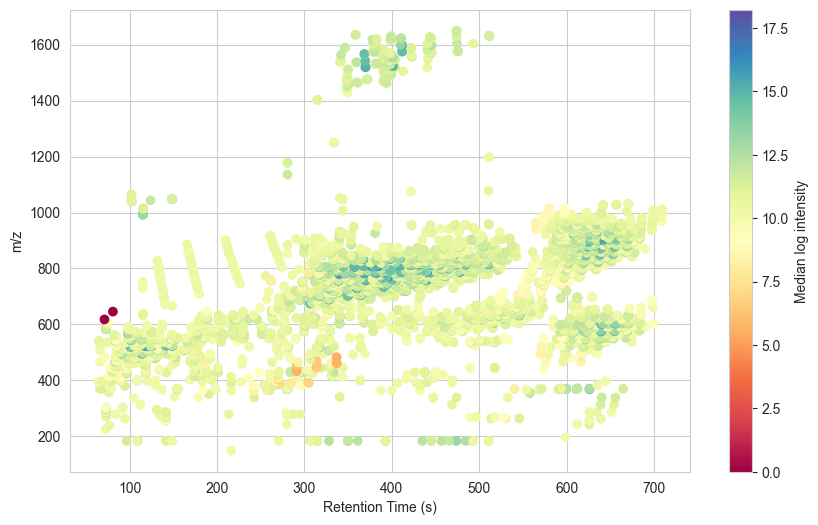

In [3]:
# RT-m/z plot

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors, colormaps 

# Compute feature median log intensity, and set up colorbar 
median_intensity = np.log1p(ds.feat_table.iloc[:, 7:]).median(axis=1).astype(float)
cmap = colormaps['Spectral']  
norm = colors.Normalize(vmin=median_intensity.min(), vmax=median_intensity.max())

# Create scatter plot
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
sc = plt.scatter(
    ds.feat_table['rt'],
    ds.feat_table['mz'],
    c=median_intensity,
    cmap=cmap,
    edgecolor=None
)
plt.xlabel('Retention Time (s)')
plt.ylabel('m/z')

# Add colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Median log intensity')


## Prepare input data

In this section, we prepare the inputs required for running **GLC**.

- We use the `glc.FeatDicts` class to construct a Python object that provides fast, dictionary-based lookups for feature **retention time (rt)** and **mass-to-charge ratio (m/z)**.

- We load a previously computed **Gaussian Graphical Model (GGM)** for this dataset.  
  When analysing their own data, users will need to estimate the GGM network directly from their feature intensity table. In this workflow, we use the [`GeneNet`](https://cran.r-project.org/web/packages/GeneNet/index.html) R package to infer the GGM and provide a Python wrapper function to call this R-based implementation. This approach requires **R to be installed and properly configured** on the system.  
  Alternatively, users may supply a precomputed GGM as a `CSV` file containing the adjacency matrix. Please refer to the dedicated tutorial for details on the expected format and estimation procedure.

- We load the **LIPID MAPS Structural Database (LMSD)**


In [4]:
# create a Python object for fast look up of feature rt and m/z
feat_dicts = glc.FeatDicts(ds.feat_table)

# load the estimated GGM for the example data
ggm = glc.GGM(ds.ggm)

# load the LMSD datbase
lm_df = glc.load_lm_database()

# features in GGM main subgraph: 4849 out of 4858


## Step 1: Mapping features to the LMSD database

The first step is to map each detected feature to entries in the **LIPID MAPS Structural Database (LMSD)**.

In this quickstart tutorial, we perform a **simple m/z-based mapping**, where each feature’s measured *m/z* is searched against the LMSD database assuming a **[M+H]+ adduct** and a **10 ppm mass tolerance**. This approach is intended as a lightweight introduction to the GLC workflow.

In subsequent tutorials, we demonstrate more sophisticated feature-to-database mapping strategies. 

For **grouped feature tables** that have undergone feature deconvolution, please refer to the alternative mapping function  
`glc.map_grouped_feature_table`, which is designed to handle grouped or consensus features.


In [5]:
# get a dictionary mapping feature 'peak_id' to a list of candidate LMID structures
feat2lmids = glc.map_ungrouped_feature_table(
    feat_dicts=feat_dicts,
    db=lm_df,
    ion_mode='pos',
    ppm_interval=10,
)

100%|██████████| 47921/47921 [00:06<00:00, 7576.26it/s]


## Step 2: GLC Lipid Class Prediction

Next, we create the **GLC model**, which combines multiple feature-to-structure matches with the **GGM network** to predict lipid classes.

The `glc.GLCModel` is used to predict **lipid subclasses**, and we use the **LMSD ontology** to derive each feature’s predicted **lipid main class**.

As output, the model produces a dictionary mapping each feature’s `peak_id` to a ranked list of the top 10 predicted lipid classes.





In [6]:
# create the model
model = glc.GLCModel(
    ggm=ggm, 
    feat_dicts=feat_dicts,
    node_ids=feat2lmids, 
    db_df=lm_df,
)
# get subclass predictions for all features
subclass_predictions = model.predict_all()
# convert subclass predictions to mainclass predictions
mainclass_predictions = model.convert2mainclass(subclass_predictions)



Predicting feature classes: 100%|██████████| 4849/4849 [00:37<00:00, 128.58it/s]


GLC is designed to systematically predict lipid classes without requiring prior annotations or MS2 data.  
Nevertheless, for this example dataset, we will load 183 features with class-level annotations to evaluate GLC's performance. 


In [7]:
# load ground-truth annotations for the example dataset
ground_truth = ds.ground_truth
ground_truth.head()

,peak_id,cpdID,cpdName,Feature Name,lm_id,lm_category,lm_mainclass,lm_subclass,m/z,Retention Time,ion,IonID,Monoisotopic_mass,chemicalFormula,logPRDKit,InChIKey,InChI,MSIAnnotationLevel
0,173,LPOS-0012,Tetradecanoylcarnitine CAR(14:0),CAR(14:0),LMFA07070107,Fatty Acyls [FA],Fatty esters [FA07],Fatty acyl carnitines [FA0707],372.308734,78.457216,[M+H]+,LPOS-0012.1,371.303559,C21H41NO4,-1.5975,PSHXNVGSVNEJBD-LJQANCHMSA-N,InChI=1S/C21H41NO4/c1-5-6-7-8-9-10-11-12-13-14...,2
1,150,LPOS-0014,Tetradecenoylcarnitine CAR(14:1),CAR(14:1),na,Fatty Acyls [FA],Fatty esters [FA07],Fatty acyl carnitines [FA0707],370.293109,65.830733,[M+H]+,LPOS-0014.1,369.287909,C21H39NO4,na,na,na,1
2,225,LPOS-0016,Palmitoylcarnitine CAR(16:0),CAR(16:0),LMFA07070004,Fatty Acyls [FA],Fatty esters [FA07],Fatty acyl carnitines [FA0707],400.339722,109.137232,[M+H]+,LPOS-0016.1,399.334859,C23H45NO4,-1.3093,XOMRRQXKHMYMOC-OAQYLSRUSA-N,InChI=1S/C23H45NO4/c1-5-6-7-8-9-10-11-12-13-14...,1
3,272,LPOS-0021,Octadecenoylcarnitine CAR(18:1),CAR(18:1),na,Fatty Acyls [FA],Fatty esters [FA07],Fatty acyl carnitines [FA0707],426.355716,118.764734,[M+H]+,LPOS-0021.1,425.350509,C25H47NO4,na,na,na,1
4,269,LPOS-0023,Octadecadienoylcarnitine CAR(18:2),CAR(18:2),na,Fatty Acyls [FA],Fatty esters [FA07],Fatty acyl carnitines [FA0707],424.340134,97.297885,[M+H]+,LPOS-0023.1,423.334859,C25H45NO4,na,na,na,2


The first row in the ground-truth data corresponds to CAR(14:0), with LMSD subclass: Fatty acyl carnitines [FA0707].  

Now, let's examine the GLC predictions for this feature:


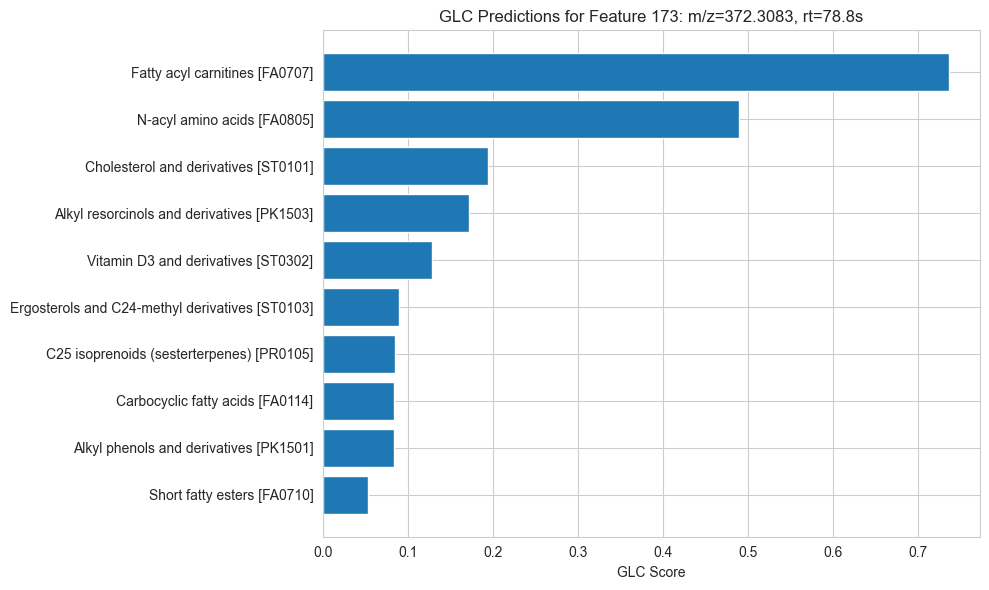

In [8]:
subclasses, scores = zip(*subclass_predictions[173])
# Figure size
plt.figure(figsize=(10, 6))

# Horizontal barplot
plt.barh(subclasses, scores)

# Labeling
plt.xlabel("GLC Score")
plt.title(f"GLC Predictions for Feature 173: m/z={feat_dicts.mz[173]:.4f}, rt={feat_dicts.rt[173]:.1f}s")
plt.gca().invert_yaxis()  # Highest value at the top

plt.tight_layout()
plt.show()

We can see that the top-ranking prediction is Fatty acyl carnitines [FA0707], indicating that in this case, GLC correctly predicted the lipid subclass. 

Next, we will evaluate its multi-class classification performance against the ground-truth annotations.

We will visualize the results using a hierarchical confusion matrix, where the blue bounding boxes correspond to the lipid main classes.  

To improve readability, predictions that do not belong to the set of ground-truth lipid classes are grouped into two additional columns:  
- Other correct main class  
- Other incorrect main class

To plot the entire confusion matrix, including all classes without truncation, set the parameter `truncate=False` in:  

```python
glc.PlotConfusionMatrices(eval_df).plot_annotation_confusion_matrix(truncate=False)
```


In [9]:
# Turn off future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

eval_df = glc.test_annotations(predictions=subclass_predictions, annot_df=ground_truth)
evaluator = glc.PlotConfusionMatrices(eval_df)
metrics = evaluator.peformance_metrics(return_df = True)
# view subclass classification performance
metrics.tail(3)


,precision,recall,f1-score,support
micro avg,0.884615,0.754098,0.814159,183.0
macro avg,0.701732,0.555023,0.592123,183.0
weighted avg,0.851615,0.754098,0.781607,183.0


In [10]:
# view mainclass classification performance
metrics = evaluator.peformance_metrics(return_df = True, level='main')
metrics.tail(3)

,precision,recall,f1-score,support
micro avg,0.867816,0.825137,0.845938,183.0
macro avg,0.745636,0.669815,0.661690,183.0
weighted avg,0.861613,0.825137,0.828242,183.0


(<Figure size 1000x800 with 2 Axes>,
 <Axes: xlabel='Predicted sub class', ylabel='True sub class'>)

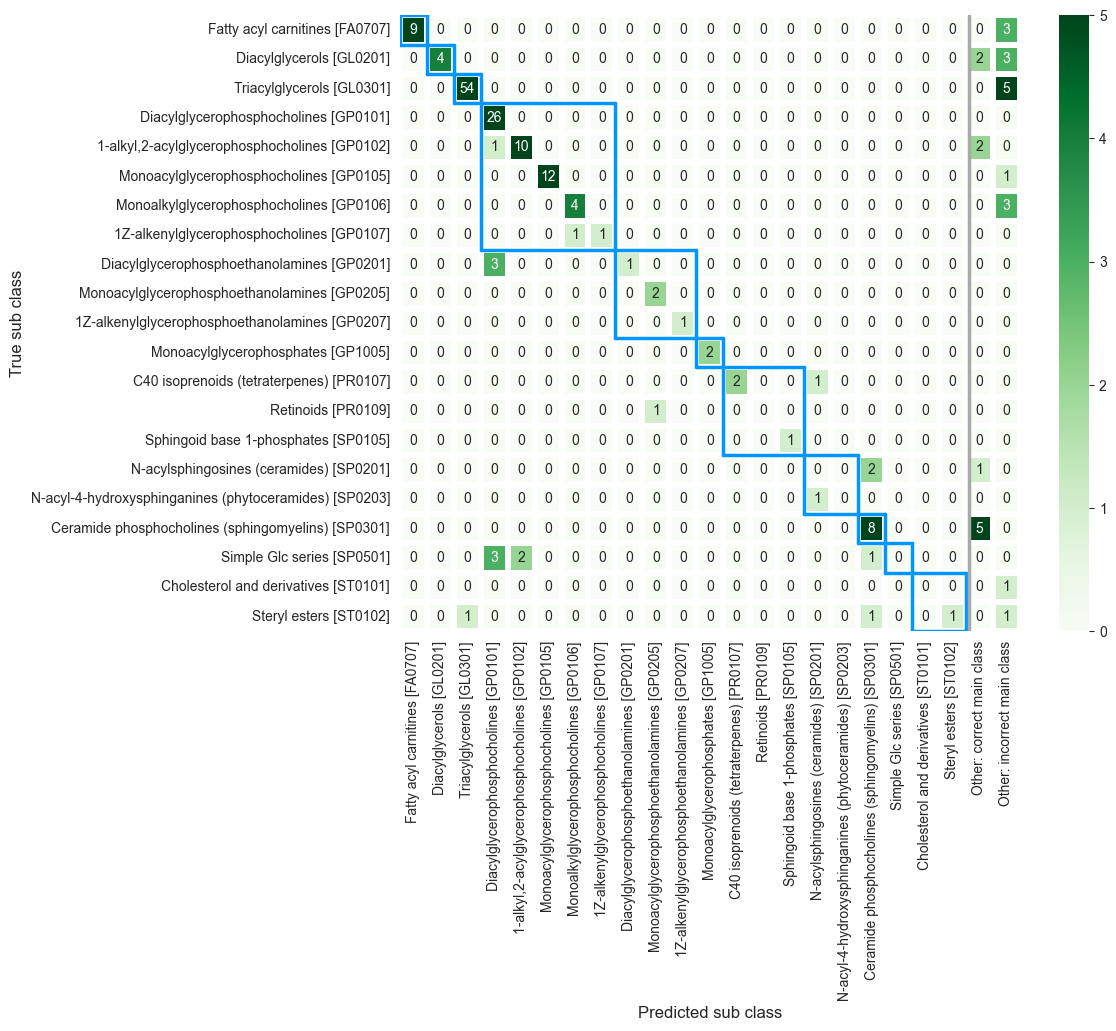

In [11]:
# plot confusion matrix
evaluator.plot_annotation_confusion_matrix()

At the subclass level, GLC achieves an overall accuracy (micro-average recall) of 75% against the ground-truth, and 83% at the main class level. This performance is based solely on considering the [M+H]+ ion for database matching for the GLC workflow.  

Remarkably, this result is obtained despite only 52% of the ground-truth features being [M+H]+. The is due to GLC leveraging the profile of database matches within the local GGM structure.

In the next tutorial, we will explore a more sophisticated strategy for database matching to further improve prediction accuracy.  

We will also cover visualizing lipid class distributions within the GGM and examining GLC quality scores.
